# Churn Prediction with PySpark using MLlib and ML Packages

Churn prediction is big business. It minimizes customer defection by predicting which customers are likely to cancel a subscription to a service. Though originally used within the telecommunications industry, it has become common practice across banks, ISPs, insurance firms, and other verticals.

The prediction process is heavily data driven and often utilizes advanced machine learning techniques. In this post, we'll take a look at what types of customer data are typically used, do some preliminary analysis of the data, and generate churn prediction models - all with PySpark and its machine learning frameworks. We'll also discuss the differences between two Apache Spark version 1.6.0 frameworks, MLlib and ML.

## Install and Run Jupyter on Spark

To run this notebook tutorial, we'll need to install [Spark](http://spark.apache.org/) and [Jupyter/IPython](http://jupyter.org/), along with Python's [Pandas](http://pandas.pydata.org/) and [Matplotlib](http://matplotlib.org/) libraries.

For the sake of simplicity, let's run PySpark in local mode, using a single machine:
>PYSPARK_DRIVER_PYTHON=ipython PYSPARK_DRIVER_PYTHON_OPTS=notebook /path/to/bin/pyspark --packages com.databricks:spark-csv_2.10:1.3.0 --master local[*]

In [170]:
# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pandas as pd
# pd.options.display.mpl_style = 'default'


from pyspark_start import *

## Fetching and Importing Churn Data

For this tutorial, we'll be using the Orange Telecoms Churn Dataset. It consists of cleaned customer activity data (features), along with a churn label specifying whether the customer canceled their subscription or not. The data can be fetched from BigML's S3 bucket, [churn-80](https://bml-data.s3.amazonaws.com/churn-bigml-80.csv) and [churn-20](https://bml-data.s3.amazonaws.com/churn-bigml-20.csv). The two sets are from the same batch, but have been split by an 80/20 ratio. We'll use the larger set for training and cross-validation purposes, and the smaller set for final testing and model performance evaluation. The two data sets have been included in this repository for convenience.

In order to read the CSV data and parse it into Spark [DataFrames](http://spark.apache.org/docs/latest/sql-programming-guide.html), we'll use the [CSV package](https://github.com/databricks/spark-csv). The library has already been loaded using the initial pyspark bin command call, so we're ready to go.

Let's load the two CSV data sets into DataFrames, keeping the header information and caching them into memory for quick, repeated access. We'll also print the schema of the sets.

In [171]:
CV_data = spark.read.load('./data/churn-bigml-80.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')

final_test_data = spark.read.load('./data/churn-bigml-20.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          inferSchema='true')
# CV_data.cache()
CV_data.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



By taking 5 rows of the CV_data variable and generating a Pandas DataFrame with them, we can get a display of what the rows look like. We're using Pandas instead of the Spark _DataFrame.show()_ function because it creates a prettier print.

In [172]:
pd.DataFrame(CV_data.take(5), columns=CV_data.columns)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [173]:
CV_data.show()

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|State|Account length|Area code|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total day charge|Total eve minutes|Total eve calls|Total eve charge|Total night minutes|Total night calls|Total night charge|Total intl minutes|Total intl calls|Total intl charge|Customer service calls|Churn|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|   

## Summary Statistics

Spark DataFrames include some [built-in functions](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) for statistical processing. The _describe()_ function performs summary statistics calculations on all numeric columns, and returns them as a DataFrame. 

In [174]:
CV_data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
State,2666,None,None,AK,WY
Account length,2666,100.62040510127532,39.56397365334985,1,243
Area code,2666,437.43885971492875,42.521018019427174,408,510
International plan,2666,None,None,No,Yes
Voice mail plan,2666,None,None,No,Yes
Number vmail messages,2666,8.021755438859715,13.61227701829193,0,50
Total day minutes,2666,179.48162040510135,54.21035022086982,0.0,350.8
Total day calls,2666,100.31020255063765,19.988162186059512,0,160
Total day charge,2666,30.512404351087813,9.215732907163497,0.0,59.64


## Correlations and Data Preparation

We can also perform our own statistical analyses, using the [MLlib statistics package](http://spark.apache.org/docs/latest/mllib-statistics.html) or other python packages. Here, we're use the Pandas library to examine correlations between the numeric columns by generating scatter plots of them.

For the Pandas workload, we don't want to pull the entire data set into the Spark driver, as that might exhaust the available RAM and throw an out-of-memory exception. Instead, we'll randomly sample a portion of the data (say 10%) to get a rough idea of how it looks. 

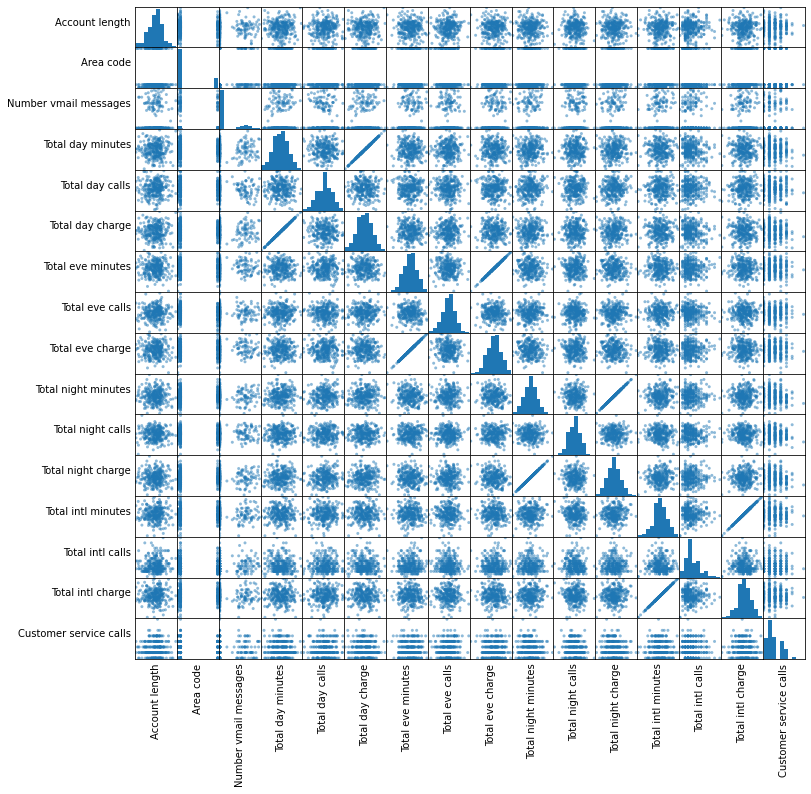

In [175]:
from pandas.plotting import scatter_matrix
numeric_features = [t[0] for t in CV_data.dtypes if t[1] == 'int' or t[1] == 'double']

sampled_data = CV_data.select(numeric_features).sample(False, 0.10).toPandas()

axs = scatter_matrix(sampled_data, figsize=(12, 12));

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

It's obvious that there are several highly correlated fields, ie _Total day minutes_ and _Total day charge_. Such correlated data won't be very beneficial for our model training runs, so we're going to remove them. We'll do so by dropping one column of each pair of correlated fields, along with the _State_ and _Area code_ columns.

While we're in the process of manipulating the data sets, let's transform the categorical data into numeric as required by the machine learning routines, using a simple user-defined function that maps Yes/True and No/False to 1 and 0, respectively.

In [176]:
# CV_data=CV_data.dropna(how="any")

In [177]:
def get_data(df, removeCols):
    df = df.drop(*removeCols) \
        .withColumn("Churn", when(df["Churn"] == 'true', 1.0).otherwise(0.0)) \
        .withColumn('International plan', when(df["International plan"] == 'Yes', 1.0).otherwise(0.0)) \
        .withColumn('Voice mail plan', when(df["Voice mail plan"] == 'Yes', 1.0).otherwise(0.0))
    return df
from pyspark.sql.functions import split, col, round, when

removeCols = ['State', 'Area code', 'Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge']

CV_data = get_data(CV_data, removeCols=removeCols)
final_test_data = get_data(final_test_data, removeCols=removeCols)

Let's take a quick look at the resulting data set.

In [178]:
pd.DataFrame(CV_data.take(5), columns=CV_data.columns)

,Account length,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Churn
0,128,0.0,1.0,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0.0
1,107,0.0,1.0,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0.0
2,137,0.0,0.0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0.0
3,84,1.0,0.0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0.0
4,75,1.0,0.0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0.0


## Using the Spark MLlib Package

The [MLlib package](http://spark.apache.org/docs/latest/mllib-guide.html) provides a variety of machine learning algorithms for classification, regression, cluster and dimensionality reduction, as well as utilities for model evaluation. The decision tree is a popular classification algorithm, and we'll be using extensively here.  

### Decision Tree Models

Decision trees have played a significant role in data mining and machine learning since the 1960's. They generate white-box classification and regression models which can be used for feature selection and sample prediction. The transparency of these models is a big advantage over black-box learners, because the models are easy to understand and interpret, and they can be readily extracted and implemented in any programming language (with nested if-else statements) for use in production environments. Furthermore, decision trees require almost no data preparation (ie normalization) and can handle both categorical and continuous data. To remedy over-fitting and improve prediction accuracy, decision trees can also be limited to a certain depth or complexity, or bundled into ensembles of trees (ie random forests).

A decision tree is a predictive model which maps observations (features) about an item to conclusions about the item's label or class. The model is generated using a top-down approach, where the source dataset is split into subsets using a statistical measure, often in the form of the Gini index or information gain via Shannon entropy. This process is applied recursively until a subset contains only samples with the same target class, or is halted by a predefined stopping criteria.

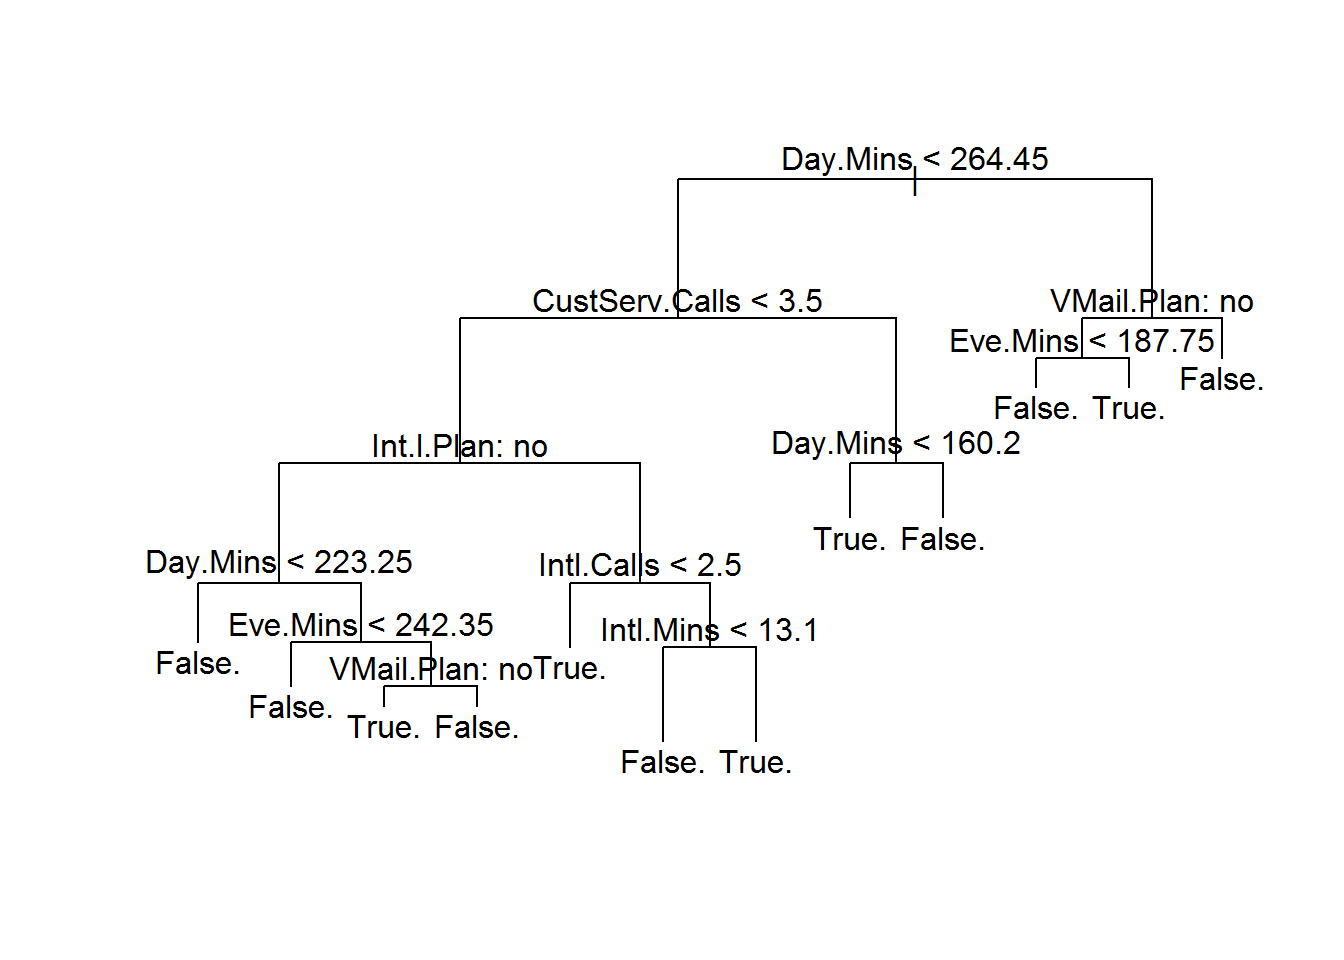

### Model Training

MLlib classifiers and regressors require data sets in a format of rows of type _LabeledPoint_, which separates row labels and feature lists, and names them accordingly. The custom _labelData()_ function shown below performs the row parsing. We'll pass it the prepared data set (CV_data) and split it further into training and testing sets. A decision tree classifier model is then generated using the training data, using a maxDepth of 2, to build a "shallow" tree. The tree depth can be regarded as an indicator of model complexity. 

In [179]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree

def labelData(data):
    # label: row[end], features: row[0:end-1]
    return data.rdd.map(lambda row: LabeledPoint(row[-1], row[:-1]))

training_data, testing_data = labelData(CV_data).randomSplit([0.8, 0.2])

print("The two first rows of the training data RDD:")
print(training_data.take(2))
print("============================")

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)
print(model.toDebugString())

The two first rows of the training data RDD:
[LabeledPoint(0.0, [107.0,0.0,1.0,26.0,161.6,123.0,195.5,103.0,254.4,103.0,13.7,3.0,1.0]), LabeledPoint(0.0, [137.0,0.0,0.0,0.0,243.4,114.0,121.2,110.0,162.6,104.0,12.2,5.0,0.0])]
DecisionTreeModel classifier of depth 2 with 5 nodes
  If (feature 4 <= 262.25)
   Predict: 0.0
  Else (feature 4 > 262.25)
   If (feature 2 in {1.0})
    Predict: 0.0
   Else (feature 2 not in {1.0})
    Predict: 1.0



The _toDebugString()_ function provides a print of the tree's decision nodes and final prediction outcomes at the end leafs. We can see that features 12 and 4 are used for decision making and should thus be considered as having high predictive power to determine a customer's likeliness to churn. It's not surprising that these feature numbers map to the fields _Customer service calls_ and _Total day minutes_. Decision trees are often used for feature selection because they provide an automated mechanism for determining the most important features (those closest to the tree root).

In [180]:
print ('Feature 2:', CV_data.columns[12])
print ('Feature 4: ', CV_data.columns[4])

Feature 2: Customer service calls
Feature 4:  Total day minutes


### Model Evaluation

Predictions of the testing data's churn outcome are made with the model's _predict()_ function and grouped together with the actual churn label of each customer data using _getPredictionsLabels()_.

We'll use MLlib's _MulticlassMetrics()_ for the model evaluation, which takes rows of (prediction, label) tuples as input. It provides metrics such as precision, recall, F1 score and confusion matrix, which have been bundled for printing with the custom _printMetrics()_ function.

In [182]:
from pyspark.mllib.evaluation import MulticlassMetrics

def getPredictionsLabels(model, test_data):
    predictions = model.predict(test_data.map(lambda r: r.features))
    return predictions.zip(test_data.map(lambda r: r.label))

def printMetrics(predictions_and_labels):
    metrics = MulticlassMetrics(predictions_and_labels)
    print('Confusion Matrix\n', metrics.confusionMatrix().toArray())
    print('Precision of True    ', metrics.precision(1))
    print('Precision of False   ', metrics.precision(0))
    print('Weighted Precision   ', metrics.weightedPrecision)
    print('Recall of True       ', metrics.recall(1))
    print('Recall of False      ', metrics.recall(0))
    print('Weighted Recall      ', metrics.weightedRecall) 
    print('FMeasure of True     ', metrics.fMeasure(1.0, 1.0))
    print('FMeasure of False    ', metrics.fMeasure(0.0, 1.0))
    print('Weighted fMeasure    ', metrics.weightedFMeasure())
    print('Accuracy             ', metrics.accuracy)

predictions_and_labels = getPredictionsLabels(model, testing_data)

printMetrics(predictions_and_labels)

Confusion Matrix
 [[444.   9.]
 [ 57.  19.]]
Precision of True     0.6785714285714286
Precision of False    0.8862275449101796
Weighted Precision    0.8563941520146312
Recall of True        0.25
Recall of False       0.9801324503311258
Weighted Recall       0.8752362948960303
FMeasure of True      0.36538461538461536
FMeasure of False     0.9308176100628931
Weighted fMeasure     0.849583380203632
Accuracy              0.8752362948960303


The overall accuracy, ie F-1 score, seems quite good, but one troubling issue is the discrepancy between the recall measures. The recall (aka sensitivity) for the Churn=False samples is high, while the recall for the Churn=True examples is relatively low. Business decisions made using these predictions will be used to retain the customers most likely to leave, not those who are likely to stay. Thus, we need to ensure that our model is sensitive to the Churn=True samples.

Perhaps the model's sensitivity bias toward Churn=False samples is due to a skewed distribution of the two types of samples. Let's try grouping the CV_data DataFrame by the _Churn_ field and counting the number of instances in each group. 

In [183]:
CV_data.groupby('Churn').count().toPandas()

,Churn,count
0,0.0,2278
1,1.0,388


### Stratified Sampling

There are roughly 6 times as many False churn samples as True churn samples. We can put the two sample types on the same footing using stratified sampling. The DataFrames _sampleBy()_ function does this when provided with fractions of each sample type to be returned.

Here we're keeping all instances of the Churn=True class, but downsampling the Churn=False class to a fraction of 388/2278.

In [184]:
stratified_CV_data = CV_data.sampleBy('Churn', fractions={0: 388./2278, 1: 1.0}).cache()

stratified_CV_data.groupby('Churn').count().toPandas()

,Churn,count
0,0.0,385
1,1.0,388


Let's build a new model using the evenly distributed data set and see how it performs.

In [185]:
training_data, testing_data = labelData(stratified_CV_data).randomSplit([0.8, 0.2])

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)

predictions_and_labels = getPredictionsLabels(model, testing_data)
printMetrics(predictions_and_labels)

Confusion Matrix
 [[63. 16.]
 [20. 51.]]
Precision of True     0.7611940298507462
Precision of False    0.7590361445783133
Weighted Precision    0.7600575436072649
Recall of True        0.7183098591549296
Recall of False       0.7974683544303798
Weighted Recall       0.76
FMeasure of True      0.7391304347826085
FMeasure of False     0.7777777777777778
Weighted fMeasure     0.7594847020933977
Accuracy              0.76


With these new recall values, we can see that the stratified data was helpful in building a less biased model, which will ultimately provide more generalized and robust predictions.

## Using the Spark ML Package

The [ML package](http://spark.apache.org/docs/latest/ml-guide.html) is the newer library of machine learning routines. It provides an API for pipelining data transformers, estimators and model selectors. We'll use it here to perform cross-validation across several decision trees with various _maxDepth_ parameters in order to find the optimal model.

### Pipelining

The ML package needs data be put in a (label: Double, features: Vector) DataFrame format with correspondingly named fields. The _vectorizeData()_ function below performs this formatting.

Next we'll pass the data through a pipeline of two transformers, _StringIndexer()_ and _VectorIndexer()_ which index the label and features fields respectively. Indexing categorical features allows decision trees to treat categorical features appropriately, improving performance. The final element in our pipeline is an estimator (a decision tree classifier) training on the indexed labels and features.

### Model Selection

Given the data set at hand, we would like to determine which parameter values of the decision tree produce the best model. We need a systematic approach to quantatively measure the performance of the models and ensure that the results are reliable. This task of model selection is often done using cross validation techniques. A common technique is k-fold cross validation, where the data is randomly split into k partitions. Each partition is used once as the testing data set, while the rest are used for training. Models are then generated using the training sets and evaluated with the testing sets, resulting in k model performance measurements. The average of the performance scores is often taken to be the overall score of the model, given its build parameters.

For model selection we can search through the model parameters, comparing their cross validation performances. The model parameters leading to the highest performance metric produce the best model.

The ML package supports k-fold cross validation, which can be readily coupled with a parameter grid builder and an evaluator to construct a model selection workflow. Below, we'll use a transformation/estimation pipeline to train our models. The cross validator will use the _ParamGridBuilder_ to iterate through the _maxDepth_ parameter of the decision tree and evaluate the models using the F1-score, repeating 3 times per parameter value for reliable results.

## K-fold validation

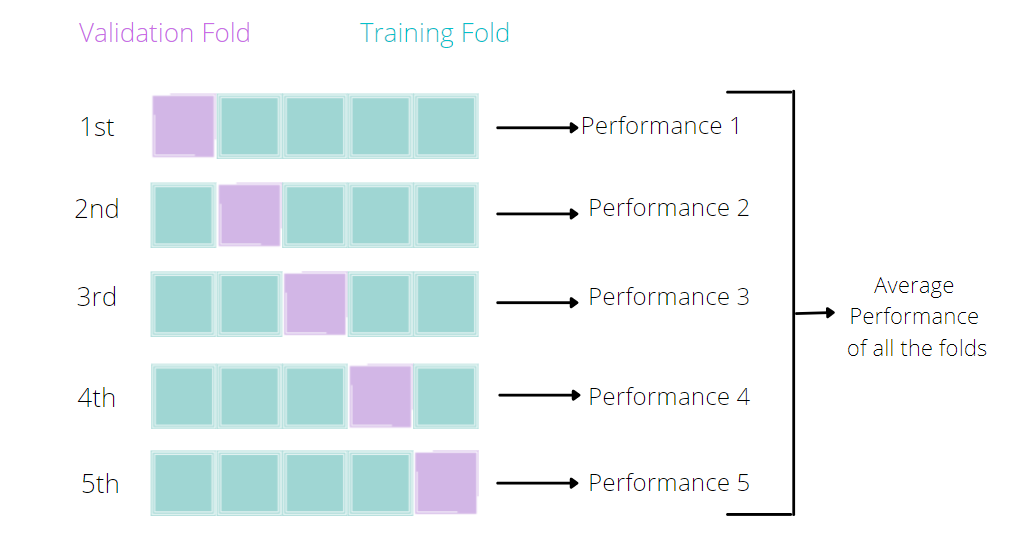

In [186]:
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def vectorizeData(data):
    return data.rdd.map(lambda r: [r[-1], Vectors.dense(r[:-1])]).toDF(['label','features'])

vectorized_CV_data = vectorizeData(stratified_CV_data)

# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(vectorized_CV_data)

# Automatically identify categorical features and index them
featureIndexer = VectorIndexer(inputCol='features',
                               outputCol='indexedFeatures',
                               maxCategories=2).fit(vectorized_CV_data)

# Train a DecisionTree model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree])

# Search through decision tree's maxDepth parameter for best model
paramGrid = ParamGridBuilder().addGrid(dTree.maxDepth, [2,3,4,5,6,7]).build()

# Set F-1 score as evaluation metric for best model selection
evaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel',
                                              predictionCol='prediction', metricName='f1')    

# Set up 3-fold cross validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

CV_model = crossval.fit(vectorized_CV_data)

# Fetch best model
tree_model = CV_model.bestModel.stages[2]
print (tree_model)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_73989ff87f95, depth=5, numNodes=37, numClasses=2, numFeatures=13


We find that the best tree model produced using the cross-validation process is one with a depth of 5. So we can assume that our initial "shallow" tree of depth 2 in the previous section was not complex enough, while trees of depth higher than 5 overfit the data and will not perform well in practice.

### Predictions and Model Evaluation

The actual performance of the model can be determined using the final_test_data set which has not been used for any training or cross-validation activities. We'll transform the test set with the model pipeline, which will map the labels and features according to the same recipe. The evaluator will provide us with the F-1 score of the predictions, and then we'll print them along with their probabilities. Predictions on new, unlabeled customer activity data can also be made using the same pipeline CV_model._transform()_ function.

In [187]:
vectorized_test_data = vectorizeData(final_test_data)

transformed_data = CV_model.transform(vectorized_test_data)
print (evaluator.getMetricName(), 'accuracy:', evaluator.evaluate(transformed_data))

predictions = transformed_data.select('indexedLabel', 'prediction', 'probability')
predictions.toPandas().head()

f1 accuracy: 0.9187070377226177


,indexedLabel,prediction,probability
0,1.0,1.0,"[0.14327485380116958, 0.8567251461988304]"
1,0.0,0.0,"[0.9761904761904762, 0.023809523809523808]"
2,0.0,0.0,"[0.9883720930232558, 0.011627906976744186]"
3,1.0,1.0,"[0.14327485380116958, 0.8567251461988304]"
4,1.0,1.0,"[0.14327485380116958, 0.8567251461988304]"


The prediction probabilities can be very useful in ranking customers by their likeliness to defect. This way, the limited resources available to the business for retention can be focused on the appropriate customers.



In [157]:
pd.concat([final_test_data.toPandas(),predictions.toPandas()['probability']],axis=1)

,Account length,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Churn,probability
0,117,0.0,0.0,0,184.5,97,351.6,80,215.8,90,8.7,4,1,0.0,"[0.12333333333333334, 0.8766666666666667]"
1,65,0.0,0.0,0,129.1,137,228.5,83,208.8,111,12.7,6,4,1.0,"[0.978494623655914, 0.021505376344086023]"
2,161,0.0,0.0,0,332.9,67,317.8,97,160.6,128,5.4,9,4,1.0,"[0.9516129032258065, 0.04838709677419355]"
3,111,0.0,0.0,0,110.4,103,137.3,102,189.6,105,7.7,6,2,0.0,"[0.12333333333333334, 0.8766666666666667]"
4,49,0.0,0.0,0,119.3,117,215.1,109,178.7,90,11.1,1,1,0.0,"[0.12333333333333334, 0.8766666666666667]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,114,0.0,1.0,26,137.1,88,155.7,125,247.6,94,11.5,7,2,0.0,"[0.12333333333333334, 0.8766666666666667]"
663,106,0.0,1.0,29,83.6,131,203.9,131,229.5,73,8.1,3,1,0.0,"[0.12333333333333334, 0.8766666666666667]"
664,60,0.0,0.0,0,193.9,118,85.0,110,210.1,134,13.2,8,3,0.0,"[0.12333333333333334, 0.8766666666666667]"
665,159,0.0,0.0,0,169.8,114,197.7,105,193.7,82,11.6,4,1,0.0,"[0.12333333333333334, 0.8766666666666667]"
